In [1]:
# Import necessary libraries
import os, mne, re
from mne.channels import make_standard_montage
import numpy as np
from glob import glob
from mne_bids import BIDSPath, write_raw_bids, read_raw_bids
from pyprep.find_noisy_channels import NoisyChannels



# Set the folder for recreate the data in bids format downsampled 
root_bids = 'C:/Users/mfbpe/Desktop/DATA/2023_Eva_Freedom/bids/'

# Set the derivatives directory path
root_derivatives = root_bids.split('/bids')[0] + '/derivatives'

# Set the image directory path
root_image = 'C:/Users/mfbpe/Desktop/DATA/2023_Eva_Freedom/images_prep_eeg/'

# Change the current working directory to the derivatives directory
os.chdir(root_derivatives)


# Get a list of all file paths with .bdf extension in the source directory
all_files_path = sorted(glob(f'{root_bids}/*/*/*_eeg.vhdr*'), key=len)

# Define a dictionary with participant numbers as keys and a list of bad channels as values + a list of bad ica components

prtp_chs_out = {'1': ['POz'], '3': [], '5': ['P3', 'P1', 'P2', 'PO3', 'PO4'], '6': ['Oz', 'O2', 'POz', 'P2', 'Iz'], '7': [], '8': ['P3', 'P1', 'POz', 'Iz', 'FT8', 'P9'], '9': ['Oz', 'P2', 'Pz', 'Iz', 'O1'], '10': ['Oz', 'O2', 'Iz', 'O1'], '11': ['POz', 'Iz'], '12': [], '13': ['P1', 'Iz'], '14': ['Oz', 'O2', 'Iz', 'O1'], '15': ['AF8', 'Fp2', 'O2', 'POz', 'Iz'], '16': ['P9', 'POz', 'P10'], '17': ['Iz', 'O2'], '19': ['Iz', 'POz', 'CP5', 'Pz'], '20': ['Oz', 'O2', 'Iz'], '21': ['P9', 'F3', 'PO3', 'O1'], '22': ['Iz'], '23': ['POz', 'Iz', 'O1'], '24': ['POz', 'Iz', 'PO3'], '25': ['Iz', 'PO8', 'O1'], '28': ['O2', 'O1'], '30': ['P1', 'Iz', 'P2', 'PO3'], '32': [], '33': ['PO3'], '34': ['Iz'], '35': [], '36': ['O1'], '37': ['Oz', 'Iz', 'POz'], '38': ['POz', 'Pz'], '39': ['O2', 'POz', 'T7', 'PO3'], '4': ['CPz', 'PO4', 'O1', 'PO7'], '26': ['POz', 'T8', 'CP6', 'C5'], '29': ['FT7', 'F7', 'F5', 'F3', 'F1', 'AF3', 'AF7', 'Fp1'], '31': ['Pz', 'O2', 'FCz', 'Oz', 'C3', 'TP7', 'CP3', 'Iz', 'P3', 'P5', 'P9', 'Fz', 'CP1', 'FC3']}


prtp_ica_out = {'1': [0, 1, 2], '3': [0, 1], '5': [0, 2], '6': [2, 4, 7], '7': [0, 1], '8': [3, 5], '9': [1, 4], '10': [1, 0], '11': [0, 3], '12': [3, 4], '13': [1, 2], '14': [0, 1], '15': [0, 1], '16': [0, 1, 4], '17': [0, 1], '19': [2, 4], '20': [0, 1], '21': [0, 2], '22': [0, 1, 4], '23': [0, 2], '24': [0, 1], '25': [0, 2, 4], '27': [1, 3], '28': [0, 4], '30': [1, 4], '32': [0, 1], '33': [0, 2], '34': [0, 1], '35': [0, 2], '36': [1, 2], '37': [0, 2], '38': [0, 1], '39': [2, 1], '4':[0, 1], '26':[3, 4], '29':[1, 2], '31':[3, 5]}



In [2]:
%%capture 
# Extract the participant number from the file path
n_part = '1'
bidspath = BIDSPath(subject=n_part, task='constraint', datatype='eeg', root=root_bids)
raw = read_raw_bids(bids_path=bidspath).load_data()

# Apply a bandpass filter to the raw data 
raw.filter(l_freq=.01, h_freq=40, n_jobs=-1)


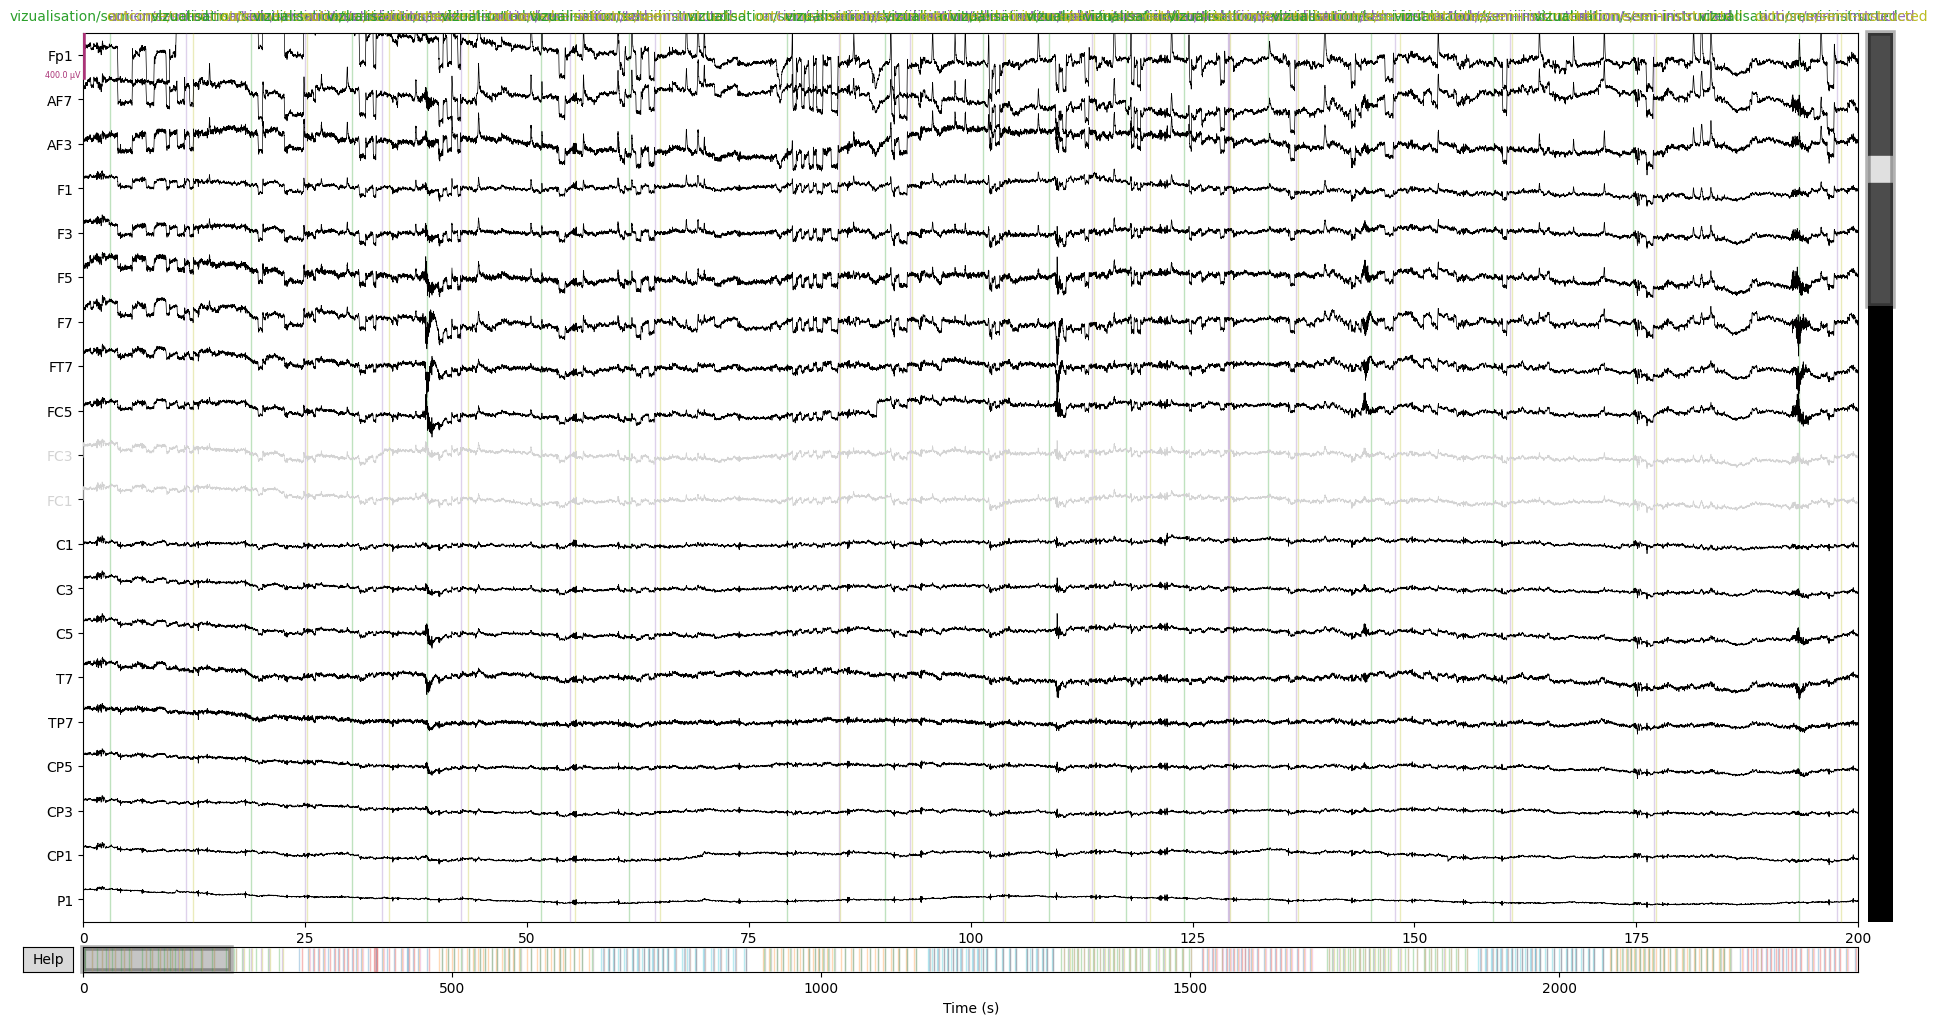

In [4]:
%matplotlib qt
raw.plot(duration=200, scalings=dict(eeg=200e-6))

In [ ]:
write_raw_bids(raw, bidspath, format='BrainVision', allow_preload=True, overwrite=True)

In [ ]:
%%capture
raw_copy = raw.copy().filter(1, None, n_jobs=-1) #to improve detection channels and ICA
# Interpolate bad channels for participants in the prtp_chs_out list
if n_part in list(prtp_chs_out):
    raw.info['bads'] = prtp_chs_out[n_part]
    raw = raw.interpolate_bads()
    raw_copy = raw_copy.interpolate_bads()
else :
    noisy= NoisyChannels(raw_copy)
    noisy.find_all_bads()
    bad_chs = noisy.get_bads()
    raw.info['bads'] = bad_chs
    raw = raw.interpolate_bads()
    raw_copy = raw_copy.interpolate_bads()
    prtp_chs_out[n_part]=bad_chs

# Perform Independent Component Analysis (ICA) on the copied data
ica = mne.preprocessing.ICA(random_state=21, max_iter='auto')
ica.fit(raw_copy)


if n_part in list(prtp_ica_out):
    ica.exclude = prtp_ica_out[n_part]
    ica.apply(raw)
fig = ica.plot_components(picks=np.arange(ica.n_components_), show = False) #create figures of the components with the one removed
# fig.savefig(f"{root_image}sub-{n_part}_ICA.png")

# del ica

# Save the preprocessed raw data
# raw.save(f"sub-{n_part}_constraint_raw.fif", overwrite=True)

# del raw, raw_copy

# create the txt file

# with open('list_bad_channels.txt', 'w') as f:
#     f.write('dict = ' + repr(prtp_chs_out) + '\n')

# with open('list_bad_ica.txt', 'w') as f:
#     f.write('dict = ' + repr(prtp_ica_out) + '\n')    


Using matplotlib as 2D backend.


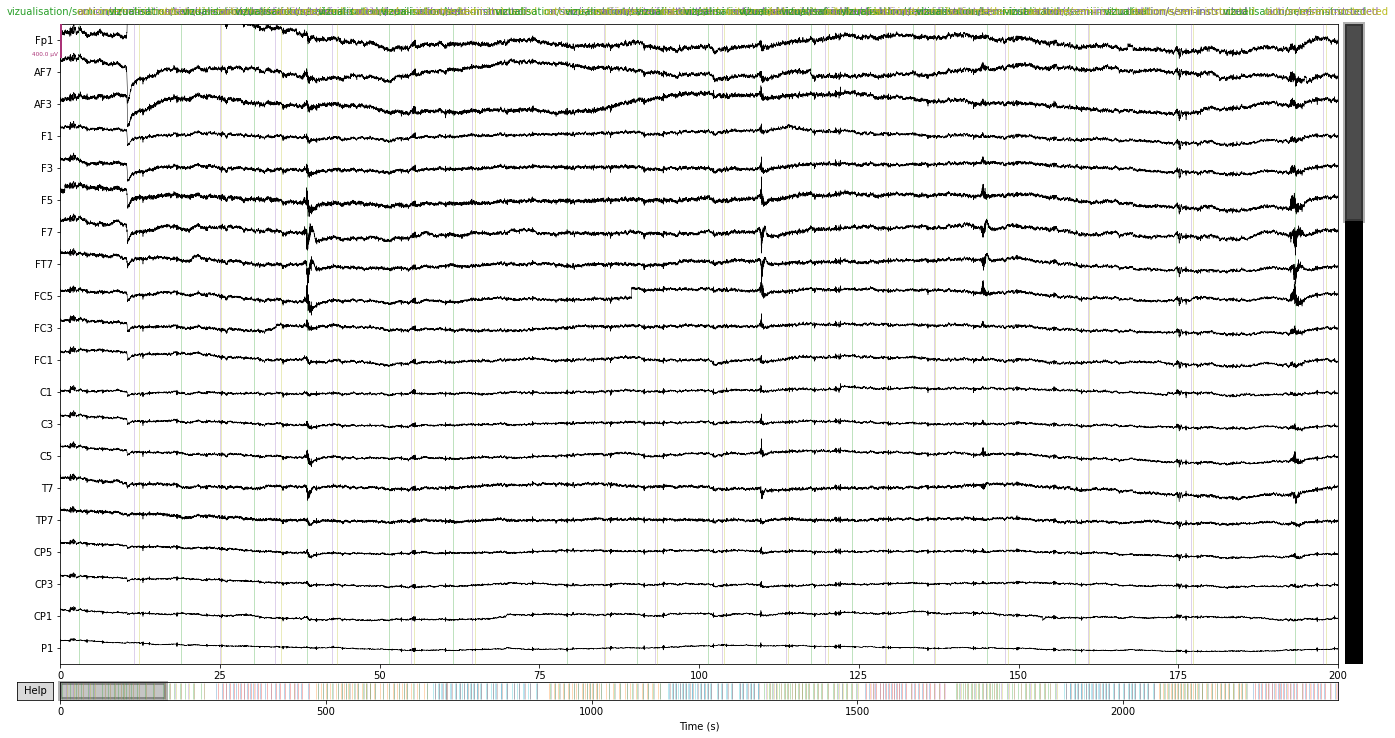

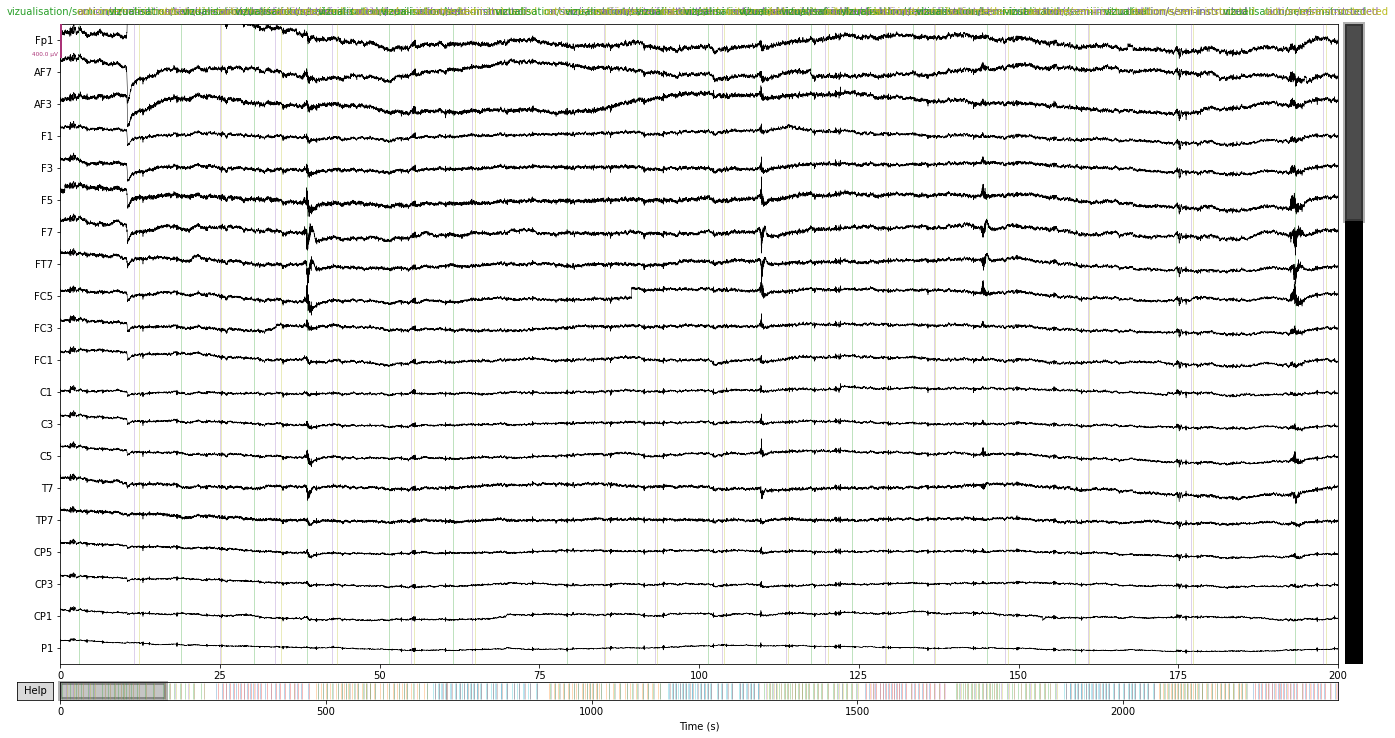

In [5]:
raw.plot(duration=200, scalings=dict(eeg=200e-6))